# This data is from 2010
____

## Section 1 - General

### 1.1 - Import Relevant Libraries

In [1]:
# import pandas and numpy

import pandas as pd
import numpy as np

# import visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns

# import urllib and BeautifulSoup to request and parse html

import urllib.request as request, urllib.parse, urllib.error
from bs4 import BeautifulSoup

# import Geocoders Library to find coordinates
from geopy.geocoders import Nominatim, GoogleV3

# import folium for maps
import folium

# importing libraries for GET requests
import requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means for clustering stage
from sklearn.cluster import KMeans

### 1.2 - Define New Functions

The following **'*get_my_table function*'**  is defined to scrape table data to a dataframe from web, based on URL and a 'key word'

In [2]:
def get_my_table(url,keyword):
    
    # getting html parsed with bs4
    html = request.urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')
    tables = soup.find_all('table')
    
    # find the table with 'keyword' in heading
    for i,table in enumerate(tables):
        if keyword in [heading.text for heading in tables[i].find_all('th')]:
            my_table = tables[i]
            print('Tables[{}] is my_table'.format(i))
        else: continue

    # analysing the number of rows to see if it matches the web
    rows = my_table.find_all('tr')
    print(('There are {} rows in my_table').format(len(rows)))
    
    # since the column names appearing in the first row in the table
    column_row = rows[0]
    col_names = [raw_col.text.strip().replace(' ','_') for raw_col in column_row.find_all('th')]
    
    # since the table data appear from first row till the last
    raw_data_rows = rows[1:-1]
    clean_data_rows = [[raw_cell.text.strip() for raw_cell in row.find_all('td')] for row in raw_data_rows]
    
    # create a temporary dataframe
    df_temp = pd.DataFrame(clean_data_rows)
    df_temp.columns = col_names
    print('This dataframe has {} rows and {} columns'.format(df_temp.shape[0],df_temp.shape[1]))
    return(df_temp)

The following **'*get_qatar_coordinates function*'**  is defined to obtain coordinates using geocoder based on a list of locations in Qatar

In [3]:
def get_qatar_coordinates(place_list):
    #setting the local parameters

    my_API = ''
    address = 'Qatar'
    geolocator = GoogleV3(api_key=my_API)
    lat_dic = dict()
    lon_dic = dict()
    null_list = list()
    n = 0
    for place in place_list:
        address = place + 'Qatar'
        location = geolocator.geocode(address)
        try:
            latitude = location.latitude
            longitude = location.longitude
            lat_dic[place] = latitude
            lon_dic[place] = longitude
        except:
            lat_dic[place] = 'None'
            lon_dic[place] = 'None'
            null_list.append(place)
            n = n+1
    if n > 0:
        print('Couldnt obtain coordinated for {} locations in Qatar.'.format(n))
        print(null_list)
    else:
        print('All coordinates obtained')
    return (lat_dic,lon_dic)

The following **'*getNearbyVenues function*'**  is defined to obtain nearby Venue detailed using FourSquare API and to generate Dataframe using the key fields and relevant data for further analysis

In [4]:
def getNearbyVenues(municipals, names, latitudes, longitudes, radius):
    
    venues_list=[]
    for municipal, name, lat, lng in zip(municipals, names, latitudes, longitudes):
          
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)

        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except: results = {}

        # return only relevant information for each nearby venue
        if len(results)>0:
            venues_list.append([(
                municipal,
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        else: continue


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Municipal','Neighborhood', 
              'Neighborhood Latitude', 
              'Neighborhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
           
    return(nearby_venues)

The following **'*return_most_common_venues function*'**  is defined to obtain number of top Venues from Dataframe

In [5]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

____

## Section 2 - Insights from the Demographics of Qatar

### 2.1 - Nationalities in Qatar

In [6]:
# obtain  for Qatar Population demographics

url = r'https://en.wikipedia.org/wiki/Demographics_of_Qatar'
keyword = 'Country'
df_temp = get_my_table(url,keyword)
df_temp.head()

Tables[8] is my_table
There are 17 rows in my_table
This dataframe has 15 rows and 3 columns


,Country,Number,percent
0,India,"650,000",25.00%
1,Qatar,"330,000",12.10%
2,Philippines,"260,000",10.00%
3,Egypt,"200,000",8.60%
4,Bangladesh,"280,000",12.10%


*Data cleaning and wrangling...*

In [7]:
df_temp['population'] = df_temp['Number'].str.replace(',','')
df_temp['population'] = df_temp['population'].astype(float)
df_population = df_temp[['Country','population']].sort_values('population', ascending=False).reset_index(drop=True)
df_population.head()

,Country,population
0,India,650000.0
1,Qatar,330000.0
2,Bangladesh,280000.0
3,Philippines,260000.0
4,Egypt,200000.0


*Visualize the **df_population** for further insights*

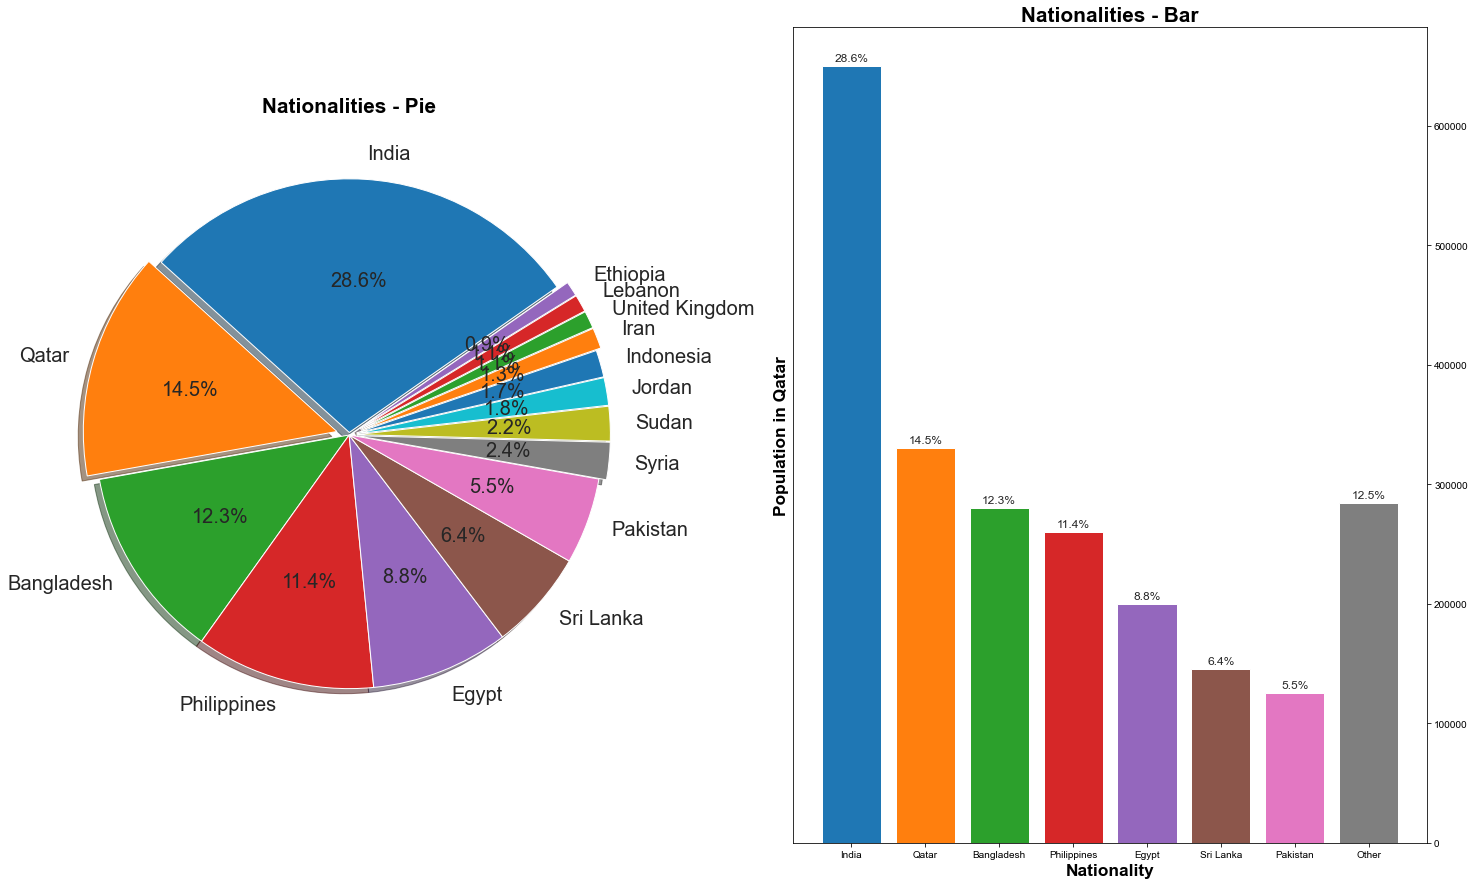

In [8]:
# difining a figure with multiple axis

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(25,15))

sns.set(style='whitegrid',context="notebook") #### setting style & color palette

explode = (0.01, 0.05, 0, 0, 0, 0, 0, 0.03, 0.03, 0.03, 0.03, 0.05, 0.05, 0.05, 0.05) #### explode factors for the pie-chart

# limit the number of segments in pie to 7

country_labels = df_population.Country[0:7].to_list()
country_labels.append('Other') #### creating 7 country labels

population_numbers = df_population.population[0:7].to_list()
population_numbers.append(df_population.population[7:].sum()) #### summing up and creating a single value for 

# create pie-chart

pie_char = ax.pie(df_population.population, labels = df_population.Country, 
              autopct='%0.1f%%', textprops={'fontsize': 20}, startangle=35, explode=explode, shadow = True, colors = sns.color_palette('tab10') )

#create bar-chart
bar_char = ax1.bar(country_labels, population_numbers, color = sns.color_palette('tab10') )

# set properties
ax.set_title("Nationalities - Pie", fontsize='xx-large', fontweight='bold')
ax1.set_title("Nationalities - Bar", fontsize='xx-large', fontweight='bold')
ax1.set_xlabel('Nationality',fontsize = 'x-large', fontweight='bold')
ax1.yaxis.tick_right()
ax1.set_ylabel('Population in Qatar',fontsize = 'x-large',fontweight='bold')

def autolabel(rects, ax):
    # getting sum of all rectangles
    
    sum_rects = 0
    for rect in rects:
        #print(rect.get_height())
        if sum_rects == 0:
            sum_rects = rect.get_height()
        else:
            sum_rects = sum_rects + rect.get_height()
    sum_rects
    
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        percentage = rect.get_height()/sum_rects
        height = rect.get_height()
        ax.annotate('{:.1%}'.format(percentage),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar_char,ax1)

popcharts_url = r'C:\Users\Prasanna Suresh\Desktop\Capstone\Coursera_Capstone\coursera_capstone\img\popcharts.jpeg'
plt.savefig(popcharts_url, bbox_inches='tight')

plt.show()

### 2.2 - Administrative Divisions , Areas and Populations in Qatar

**Step 1:** Obtain the data relevant to the Administrative division in Qatar

In [9]:
# obtain  for Qatar Admin divisions

url = r'https://en.wikipedia.org/wiki/List_of_cities_in_Qatar'
keyword = 'City/district name'
df_temp = get_my_table(url,keyword)
df_temp.head()

Tables[0] is my_table
There are 171 rows in my_table
This dataframe has 169 rows and 4 columns


,City/district_name,Population_(2010),Area_(km),Description
0,Abu Dhalouf,16,16,Located in the municipality of Al Shamal.
1,Abu Hamour,7,7,Located in the municipality of Al Rayyan.
2,Abu Samra,"1,065",824.9,Located in the municipality of Al Rayyan.
3,Ain Khaled,7,7,Located in the municipality of Al Rayyan.
4,Ain Sinan,17,17,Located in the municipality of Al Shamal.


*Data cleaning and wrangling...*

In [10]:
# drop empty rows
df_temp.dropna(axis=0, inplace=True)

# Clean up numbers and descriptions
df_temp['Description'] = df_temp['Description'].str[:-1]
df_temp ['Municipality'] = df_temp['Description'].str.replace('Located in the municipality of ','')

df_temp['Neighborhood'] = df_temp['City/district_name']

# note: population and area data in this table is incomplete and hence will not be used in analysis

# create the dataframe
df_admindiv = df_temp[['Municipality','Neighborhood']].reset_index(drop=True)
df_admindiv.head()

,Municipality,Neighborhood
0,Al Shamal,Abu Dhalouf
1,Al Rayyan,Abu Hamour
2,Al Rayyan,Abu Samra
3,Al Rayyan,Ain Khaled
4,Al Shamal,Ain Sinan


In [11]:
Municipals = None
for municipal in df_admindiv.Municipality.unique():
    if Municipals is None:
        Municipals = municipal
    else:
        Municipals = Municipals + ', ' + municipal
Municipals

print('\nQatar has {} Municpalities and {} Neighborhoods as per the data available from Wikipedia.\n'.format(len(df_admindiv.Municipality.unique()),df_admindiv.shape[0]))
print('The Municipalities in Qatar are {}\n'.format(Municipals))


Qatar has 7 Municpalities and 148 Neighborhoods as per the data available from Wikipedia.

The Municipalities in Qatar are Al Shamal, Al Rayyan, Doha, Umm Salal, Al Daayen, Al Khor, Al Wakrah



**Step 2:** Obtain the data relevant to the Areas and Population withing administrative division of Qatar

In [12]:
# obtain popolations and area data for Qatar municipalities

url = r'https://en.wikipedia.org/wiki/Municipalities_of_Qatar'
keyword = 'Key'
df_temp = get_my_table(url,keyword)
df_temp.head()

Tables[1] is my_table
There are 10 rows in my_table
This dataframe has 8 rows and 6 columns


,Key,Municipality(Baladiyah),بلدية,Population(2015)[5],Area(km²),Area(mi²)
0,1,Al Shamal,الشمال,"8,794",859.8,331.9
1,2,Al Khor,الخور,"202,031","1,613.3",622.8
2,3,Al-Shahaniya,الشحانية,"187,571","3,309.0","1,277.6"
3,4,Umm Salal,أم صلال,"90,835",318.4,122.9
4,5,Al Daayen,الضعاين,"54,339",290.2,112.0


*Data cleaning and wrangling...*

In [13]:
df_temp = df_temp[['Municipality(Baladiyah)','Population(2015)[5]','Area(km²)']]

df_temp['Population'] = df_temp['Population(2015)[5]'].str.replace(',','')
df_temp['Population'] = df_temp['Population'].astype('float')

df_temp['Area'] = df_temp['Area(km²)'].str.replace(',','')
df_temp['Area'] = df_temp['Area'].astype('float')
df_temp['Municipality'] = df_temp['Municipality(Baladiyah)']
 
df_areavspop = df_temp[['Municipality','Population','Area']]
df_areavspop

,Municipality,Population,Area
0,Al Shamal,8794.0,859.8
1,Al Khor,202031.0,1613.3
2,Al-Shahaniya,187571.0,3309.0
3,Umm Salal,90835.0,318.4
4,Al Daayen,54339.0,290.2
5,Ad Dawhah (Doha),956457.0,202.7
6,Al Rayyan,605712.0,2450.0
7,Al Wakrah,299037.0,2577.7


*Visualize the **df_areavspop** and **admindiv_grouped** for further insights*

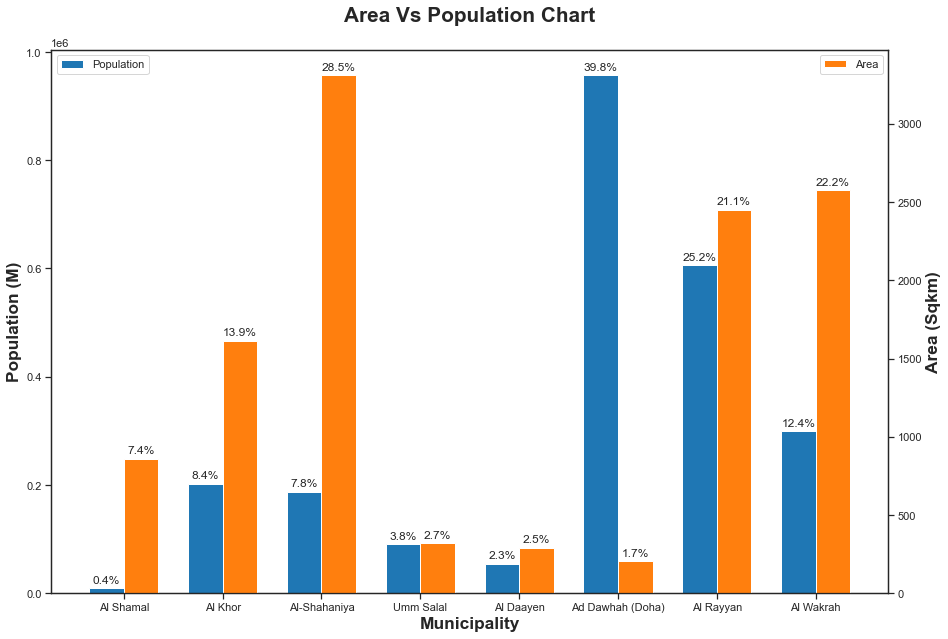

In [14]:
df_new = df_areavspop

# set style and other paramerter for the Combi-barchart
sns.set(style='ticks',context="notebook")
x = np.arange(df_new.shape[0])
width = 0.35

# create figure and twin axes
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax1 = ax.twinx()

# create color palette according to 'Population' and 'Area' ranks
    #rank1 = df_new['Population'].argsort().argsort()
    #palette1 = sns.color_palette('Reds',df_new.shape[0])
    #palette_ranked1 = np.array(palette1)[rank1]

    #rank2 = df_new['Area'].argsort().argsort()
    #palette2 = sns.color_palette('Greens',df_new.shape[0])
    #palette_ranked2 = np.array(palette2)[rank2]

# create bar-charts
bar1 = ax.bar(x-width/2, df_new["Population"], width, label = 'Population', color = 'tab:blue')
bar2 = ax1.bar(x+width/2, df_new["Area"], width, label = 'Area', color = 'tab:orange')

# set ax axit properties
ax.set_xlabel('Municipality',fontsize='x-large',fontweight='bold')
ax.set_ylabel('Population (M)',fontsize='x-large',fontweight='bold')
ax.set_title('Area Vs Population Chart\n',fontsize='xx-large',fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_new.Municipality)
ax.legend(loc=2)

# set ax1 axis properties
ax1.set_ylabel('Area (Sqkm)',fontsize='x-large',fontweight='bold')
ax1.legend(loc=0)

def autolabel(rects, ax):
    # getting sum of all rectangles
    
    sum_rects = 0
    for rect in rects:
        #print(rect.get_height())
        if sum_rects == 0:
            sum_rects = rect.get_height()
        else:
            sum_rects = sum_rects + rect.get_height()
    sum_rects
    
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        percentage = rect.get_height()/sum_rects
        height = rect.get_height()
        ax.annotate('{:.1%}'.format(percentage),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1,ax)
autolabel(bar2,ax1)

# saving figure
areavspop_url = r'C:\Users\Prasanna Suresh\Desktop\Capstone\Coursera_Capstone\coursera_capstone\img\areavspop.jpeg'
plt.savefig(areavspop_url, bbox_inches='tight')

plt.show()

____

## Section 3 - Visualize on Maps

### 3.1 - Finding Coordinates of Qatar

In [15]:
# assign API key to be reused in following sections

my_API = ''

# Lets find the coordinate of Qatar to create a Map so that we can superimpose all the Municipals to visualize in a map

address = 'Qatar'

geolocator = GoogleV3(api_key=my_API)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinate of Qatar are 25.354826, 51.183884.


### 3.2 - Finding Coordinates of Municipalities and Cities in Qatar

Obtain latitudes and longitudes for the Municipalities and Neighborhoods in Qatar

In [16]:
municipal_list = df_admindiv.Municipality.unique()

municpal_coordinates = get_qatar_coordinates(municipal_list)

All coordinates obtained


In [17]:
neighborhood_list = df_admindiv.Neighborhood

neighborhood_coordinates = get_qatar_coordinates(neighborhood_list)

Couldnt obtain coordinated for 2 locations in Qatar.
['Jabal Thuaileb', 'Lebday']


Add the above coordinates in to ***df_admindiv*** dataframe

In [18]:
# create new columns for the coordinates and assign the same name as locations

df_admindiv['municipal_lat'] = df_admindiv['Municipality']
df_admindiv['municipal_lon'] = df_admindiv['Municipality']
df_admindiv['neigh_lat'] = df_admindiv['Neighborhood']
df_admindiv['neigh_lon'] = df_admindiv['Neighborhood']

# add the coordinates in to the Dataframe using the above 'municpal_coordinates' and 'neighborhood_coordinates' dictionaries

for i, loc_name in enumerate(df_admindiv.municipal_lat):
    try:
        df_admindiv.loc[i,'municipal_lat'] = municpal_coordinates[0][loc_name]
        df_admindiv.loc[i,'municipal_lon'] = municpal_coordinates[1][loc_name]
    except: continue
        
for i, loc_name in enumerate(df_admindiv.neigh_lat):
    try:
        df_admindiv.loc[i,'neigh_lat'] = neighborhood_coordinates[0][loc_name]
        df_admindiv.loc[i,'neigh_lon'] = neighborhood_coordinates[1][loc_name]
    except: continue
        
df_admindiv.head()

,Municipality,Neighborhood,municipal_lat,municipal_lon,neigh_lat,neigh_lon
0,Al Shamal,Abu Dhalouf,26.1183,51.2157,26.1294,51.1998
1,Al Rayyan,Abu Hamour,25.2523,51.4389,25.2388,51.4914
2,Al Rayyan,Abu Samra,25.2523,51.4389,24.7502,50.8522
3,Al Rayyan,Ain Khaled,25.2523,51.4389,25.2258,51.4572
4,Al Shamal,Ain Sinan,26.1183,51.2157,26.0174,51.3782


### 3.3 - Plotting the Maps

In [19]:
# create map of Qatar using latitude and longitude values

qatar_map = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
import string
for lat, long, municipal in zip(df_admindiv.municipal_lat.unique(), df_admindiv.municipal_lon.unique(),
                                df_admindiv.Municipality.unique()):
    label = '{}, {}'.format(municipal, 'Qatar')
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, long],
        radius=5,
        popup=label,
        icon=folium.Icon(color='green', icon='info-sign'),
        parse_html=True).add_to(qatar_map)  

for lat, long, neighborhood, municipal in zip(df_admindiv.neigh_lat, df_admindiv.neigh_lon, 
                                              [neigh.replace('`','') for neigh in df_admindiv.Neighborhood],df_admindiv.Municipality):
    
    # replacing '~' since html parsing fails during folium rendering and try/except to compensate any missing geocords.
    try:
        label = '{}, {}'.format(neighborhood, municipal)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, long],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(qatar_map)
    except: continue

qatar_map

____

## Section 4 - Neighborhoods analysis

In [20]:
#Setting up Frousquare credentials and other search parameters

CLIENT_ID = '5ROK32HYDJCZ5LPXBBIJWULIPBQQKRRB2FXCPLZB0MC3P0IH' # your Foursquare ID
CLIENT_SECRET = 'KNXGCE5K11BWJCHRBHQHA4E1YVZA4EIPODIQQW3DX352HOH2' # your Foursquare Secret
VERSION = '20200731' # Foursquare API version
radius = 500
limit = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5ROK32HYDJCZ5LPXBBIJWULIPBQQKRRB2FXCPLZB0MC3P0IH
CLIENT_SECRET:KNXGCE5K11BWJCHRBHQHA4E1YVZA4EIPODIQQW3DX352HOH2


### 4.1 - Gathering venues data using Foursquare

In [21]:
qatar_venues = getNearbyVenues(df_admindiv.Municipality,df_admindiv.Neighborhood,df_admindiv.neigh_lat,df_admindiv.neigh_lon, radius)
qatar_venues.head()

,Municipal,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Al Rayyan,Abu Hamour,25.238806,51.491358,Applebee's Neighborhood Grill & Bar,25.240699,51.494203,Cuban Restaurant
1,Al Rayyan,Al Aziziya,25.242595,51.446709,Al Safir Restaurant,25.244086,51.444953,Fast Food Restaurant
2,Al Rayyan,Baaya,25.267669,51.438833,Blue at Grand Heritage Doha,25.268933,51.438573,Restaurant
3,Al Rayyan,Baaya,25.267669,51.438833,Grand Heritage Doha Hotel and Spa,25.269109,51.438325,Hotel
4,Al Rayyan,Baaya,25.267669,51.438833,Agora at Grand Heritage Hotel,25.268821,51.437978,Turkish Restaurant


In [22]:
print('Obtained {} Venue results from the Frousquare for Qatar.'.format(qatar_venues.shape[0]))

Obtained 1153 Venue results from the Frousquare for Qatar.


### 4.2 - Analysing and Visualising the Foursquare venue results

Lets figure out how many Neighborhoods have tangible result from the above Foursquare search for nearby Venues

In [23]:
print('Out of total {} Neighborhoods in Qatar,\n--> Foursquare found Venue data for {} Neighborhoods\
based on the above search request in Section 4.1\n---> Results for {} Neighborhoods is unavailable\
and will be excluded from this project'.format(
    len(df_admindiv['Neighborhood'].unique()),
    len(qatar_venues['Neighborhood'].unique()),
    len(df_admindiv['Neighborhood'].unique())-len(qatar_venues['Neighborhood'].unique())))

Out of total 148 Neighborhoods in Qatar,
--> Foursquare found Venue data for 103 Neighborhoodsbased on the above search request in Section 4.1
---> Results for 45 Neighborhoods is unavailableand will be excluded from this project


Group ***df_admindiv*** and count the Total number of Neighborhoods in each municipal 

In [24]:
admindiv_grouped = df_admindiv[['Municipality','Neighborhood']].groupby('Municipality').count()
admindiv_grouped.columns = ['Neighborhood_count']
admindiv_grouped = admindiv_grouped.sort_values('Municipality', ascending=False).reset_index()
admindiv_grouped

,Municipality,Neighborhood_count
0,Umm Salal,5
1,Doha,64
2,Al Wakrah,10
3,Al Shamal,6
4,Al Rayyan,44
5,Al Khor,7
6,Al Daayen,12


Group ***qatar_venues*** and count the Total number of Neighborhoods in each municipal 

In [25]:
qatar_venues_grouped = qatar_venues[['Municipal','Neighborhood','Venue']].groupby(['Municipal','Neighborhood'],as_index=False).count()
qatar_venues_grouped.columns=['Municipal','Neighborhood','Venue_Count']
qatar_venues_grouped.head()

,Municipal,Neighborhood,Venue_Count
0,Al Daayen,Al Daayen,1
1,Al Daayen,Al Ebb,6
2,Al Daayen,Al Kheesa,2
3,Al Daayen,Jeryan Jenaihat,1
4,Al Daayen,Leabaib,3


In [26]:
qatar_venues_regrouped = qatar_venues_grouped[['Municipal','Neighborhood']].groupby('Municipal').count().sort_values('Municipal',ascending=False).reset_index()
qatar_venues_regrouped.columns=['Municipal','Neighborhood_count']
qatar_venues_regrouped

,Municipal,Neighborhood_count
0,Umm Salal,3
1,Doha,55
2,Al Wakrah,6
3,Al Shamal,1
4,Al Rayyan,27
5,Al Khor,4
6,Al Daayen,7


In [27]:
df_difference = admindiv_grouped
df_difference['Delta'] = admindiv_grouped['Neighborhood_count']-qatar_venues_regrouped['Neighborhood_count']
df_difference['Delta%'] = df_difference['Delta']/admindiv_grouped['Neighborhood_count']
df_difference.head()

,Municipality,Neighborhood_count,Delta,Delta%
0,Umm Salal,5,2,0.400000
1,Doha,64,9,0.140625
2,Al Wakrah,10,4,0.400000
3,Al Shamal,6,5,0.833333
4,Al Rayyan,44,17,0.386364


Lets try to visualize what Numbers and Percentage of Neighborhoods from each Municipality has no records of nearby Venues from Foursquare

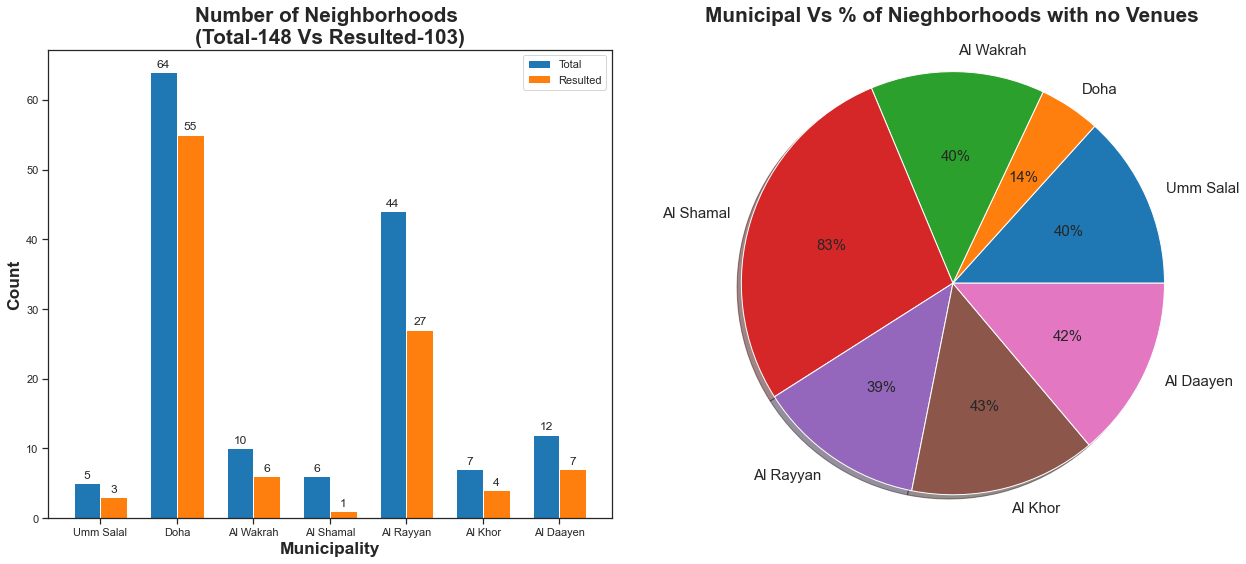

In [28]:
# set style and other paramerter for the Combi-barchart
sns.set(style='ticks',context="notebook")
x = np.arange(admindiv_grouped.shape[0])
width = 0.35

# create figure and twin axes
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# create bar-charts
bar1 = ax.bar(x-width/2, admindiv_grouped.Neighborhood_count, width, label = 'Total', color = 'tab:blue')
bar2 = ax.bar(x+width/2, qatar_venues_regrouped.Neighborhood_count, width, label = 'Resulted', color = 'tab:orange')

# set ax axit properties
ax.set_xlabel('Municipality',fontsize='x-large',fontweight='bold')
ax.set_ylabel('Count',fontsize='x-large',fontweight='bold')
ax.set_title('Number of Neighborhoods \n(Total-{} Vs Resulted-{})'.format(
    admindiv_grouped.Neighborhood_count.sum(),qatar_venues_regrouped.Neighborhood_count.sum()),fontsize='xx-large',fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(admindiv_grouped.Municipality)
ax.legend(loc=0)

def autolabel(rects, ax):
    # getting sum of all rectangles
       
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1,ax)
autolabel(bar2,ax)

# create pie-chart
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = float(pct*total)
        return '{:.0f}%'.format(val)
    return my_format

piechar = ax1.pie(df_difference['Delta%'], labels = df_difference.Municipality, autopct= autopct_format(df_difference['Delta%']),
                  textprops={'fontsize': 15}, startangle=0, shadow = True, colors = sns.color_palette('tab10'))

# set ax properties
ax1.axis('equal')
ax1.set_title('Municipal Vs % of Nieghborhoods with no Venues\n',fontsize='xx-large',fontweight='bold')
#ax1.legend(labels = df_difference.Municipality)

# saving figure
TotalVsResultedNeigh_url = r'C:\Users\Prasanna Suresh\Desktop\Capstone\Coursera_Capstone\coursera_capstone\img\TotalVsResultedNeigh.jpeg'
plt.savefig(TotalVsResultedNeigh_url, bbox_inches='tight')

plt.tight_layout()

From the above result, it is clear that Al Shamal to be removed from the further analysis due to the lack of Venue data

Now, lets analyse the Venue result for Neighborhood in order to use in the final section of this project

In [29]:
print('-> There are total {} Neighborhoods with at least one results from Frousquare.\n'.format(qatar_venues_grouped['Venue_Count'].shape[0]))
print('--> The average number of venues per Neighborhood is {:.0f}.'.format(qatar_venues_grouped.Venue_Count.mean()))
print('---> The number of Neighborhoods with more venue results than Average is {}.\n'.format(qatar_venues_grouped[qatar_venues_grouped['Venue_Count']>qatar_venues_grouped.Venue_Count.mean()].shape[0]))
print('--> The Median of venues per Neighborhood is {:.0f}.'.format(qatar_venues_grouped.Venue_Count.median()))
print('---> The number of Neighborhoods with more venue results than Median is {}.\n'.format(qatar_venues_grouped[qatar_venues_grouped['Venue_Count']>qatar_venues_grouped.Venue_Count.median()].shape[0]))
print('--> The Mode of venues per Neighborhood is {}.'.format(qatar_venues_grouped.Venue_Count.mode()[1]))
print('---> The number of Neighborhoods with more venue results than Mode is {}.'.format(qatar_venues_grouped[qatar_venues_grouped['Venue_Count']>qatar_venues_grouped.Venue_Count.mode()[1]].shape[0]))

-> There are total 103 Neighborhoods with at least one results from Frousquare.

--> The average number of venues per Neighborhood is 11.
---> The number of Neighborhoods with more venue results than Average is 30.

--> The Median of venues per Neighborhood is 5.
---> The number of Neighborhoods with more venue results than Median is 51.

--> The Mode of venues per Neighborhood is 4.
---> The number of Neighborhoods with more venue results than Mode is 57.


Considering above result chosing  Neighborhoods that is having more than 4 venue results for the comparison in this Capstone.

In [30]:
qatar_venues_grouped_filtered = qatar_venues_grouped[qatar_venues_grouped['Venue_Count']>qatar_venues_grouped['Venue_Count'].mode()[1]]
qatar_venues_grouped_filtered.head()

,Municipal,Neighborhood,Venue_Count
1,Al Daayen,Al Ebb,6
7,Al Khor,Al Jeryan,25
8,Al Khor,Al Khor,10
13,Al Rayyan,Al Gharrafa,6
16,Al Rayyan,Al Nasraniya,5


Lets find the division of chosed Neighborhoods in each Municipality as follows

In [31]:
df_temp = qatar_venues_grouped_filtered[['Municipal','Neighborhood']].groupby('Municipal').count().reset_index()
df_temp.columns = ['Municipal','Number of Neighborhoods Chosen']
df_temp

,Municipal,Number of Neighborhoods Chosen
0,Al Daayen,1
1,Al Khor,2
2,Al Rayyan,8
3,Al Wakrah,3
4,Doha,41
5,Umm Salal,2


In [32]:
df_admindiv_chosen = df_admindiv[df_admindiv['Neighborhood'].isin(qatar_venues_grouped_filtered['Neighborhood'])].reset_index(drop=True)
df_admindiv_chosen.head()

,Municipality,Neighborhood,municipal_lat,municipal_lon,neigh_lat,neigh_lon
0,Al Rayyan,Baaya,25.2523,51.4389,25.2677,51.4388
1,Doha,Barahat Al Jufairi,25.2854,51.531,25.282,51.5349
2,Doha,Al Bidda,25.2854,51.531,25.2919,51.5216
3,Doha,Dahl Al Hamam,25.2854,51.531,25.3335,51.4802
4,Doha,Doha International Airport,25.2854,51.531,25.2609,51.6138


### 4.3 - Mapping the Chosen Neighborhoods prior to clustering

In [33]:
# create map of Qatar using latitude and longitude values

qatar_chosen_map = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
import string
for lat, long, municipal in zip(df_admindiv_chosen.municipal_lat.unique(), df_admindiv_chosen.municipal_lon.unique(),
                                df_admindiv_chosen.Municipality.unique()):
    label = '{}, {}'.format(municipal, 'Qatar')
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, long],
        radius=5,
        popup=label,
        icon=folium.Icon(color='green', icon='info-sign'),
        parse_html=True).add_to(qatar_chosen_map)  

for lat, long, neighborhood, municipal in zip(df_admindiv_chosen.neigh_lat, df_admindiv_chosen.neigh_lon, 
                                              [neigh.replace('`','') for neigh in df_admindiv_chosen.Neighborhood],df_admindiv_chosen.Municipality):
    
    # replacing '~' since html parsing fails during folium rendering and try/except to compensate any missing geocords.
    try:
        label = '{}, {}'.format(neighborhood, municipal)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, long],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(qatar_chosen_map)
    except: continue

qatar_chosen_map

## Section 5 - Analysing the chosen Neighborhoods

Lets filter the Dataframe resulted from Foursquare search based on the Neighborhoods in the above map

In [34]:
qatar_venues.head()

,Municipal,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Al Rayyan,Abu Hamour,25.238806,51.491358,Applebee's Neighborhood Grill & Bar,25.240699,51.494203,Cuban Restaurant
1,Al Rayyan,Al Aziziya,25.242595,51.446709,Al Safir Restaurant,25.244086,51.444953,Fast Food Restaurant
2,Al Rayyan,Baaya,25.267669,51.438833,Blue at Grand Heritage Doha,25.268933,51.438573,Restaurant
3,Al Rayyan,Baaya,25.267669,51.438833,Grand Heritage Doha Hotel and Spa,25.269109,51.438325,Hotel
4,Al Rayyan,Baaya,25.267669,51.438833,Agora at Grand Heritage Hotel,25.268821,51.437978,Turkish Restaurant


In [35]:
qatar_venues_chosen = qatar_venues[qatar_venues['Neighborhood'].isin(qatar_venues_grouped_filtered['Neighborhood'])].reset_index(drop=True)
print(qatar_venues_chosen.shape)
qatar_venues_chosen.head()

(1040, 8)


,Municipal,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Al Rayyan,Baaya,25.267669,51.438833,Blue at Grand Heritage Doha,25.268933,51.438573,Restaurant
1,Al Rayyan,Baaya,25.267669,51.438833,Grand Heritage Doha Hotel and Spa,25.269109,51.438325,Hotel
2,Al Rayyan,Baaya,25.267669,51.438833,Agora at Grand Heritage Hotel,25.268821,51.437978,Turkish Restaurant
3,Al Rayyan,Baaya,25.267669,51.438833,Movenpick Hotel Al Aziziyah Doha,25.269106,51.438392,Hotel
4,Al Rayyan,Baaya,25.267669,51.438833,Victoria Tea Lounge at Grand Heritage Doha,25.269070,51.438437,Tea Room


Lets create one hot encoding with the Venue category for each Neighborhood

In [36]:
# one hot encoding
qatar_onehot = pd.get_dummies(qatar_venues_chosen[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
qatar_onehot['Neighborhood'] = qatar_venues_chosen['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [qatar_onehot.columns[-1]] + list(qatar_onehot.columns[:-1])
qatar_onehot = qatar_onehot[fixed_columns]

qatar_onehot.head()

,Neighborhood,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,...,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Track,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Wings Joint
0,Baaya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Baaya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Baaya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Baaya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Baaya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [37]:
qatar_grouped = qatar_onehot.groupby('Neighborhood').mean().reset_index()
print(qatar_grouped.shape)
qatar_grouped.head()

(57, 172)


,Neighborhood,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,...,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Track,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Wings Joint
0,Ad Dawhah al Jadidah,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,Al Bidda,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.166667,0.000000,0.0,0.0,0.0,0.0
2,Al Dafna,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,...,0.0,0.0,0.181818,0.0,0.000000,0.090909,0.0,0.0,0.0,0.0
3,Al Ebb,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,Al Egla,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


## Section 6 - Clustering the chosen Neighborhoods

### 6.1 Clustering for residents

In [38]:
# set number of clusters
kclusters = 10

qatar_grouped_clustering = qatar_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(qatar_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 2, 2, 4, 9, 8, 2, 2, 2, 2])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = qatar_grouped['Neighborhood']

for ind in np.arange(qatar_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(qatar_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ad Dawhah al Jadidah,Hotel,Indonesian Restaurant,BBQ Joint,Department Store,Fast Food Restaurant,Restaurant,Bakery,Middle Eastern Restaurant,Health & Beauty Service,Food
1,Al Bidda,Park,Intersection,Middle Eastern Restaurant,Metro Station,Track,Falafel Restaurant,Flower Shop,Flea Market,Fish & Chips Shop,Filipino Restaurant
2,Al Dafna,Theater,American Restaurant,Intersection,Seafood Restaurant,Trail,Indian Restaurant,Coffee Shop,Garden,Athletics & Sports,Falafel Restaurant
3,Al Ebb,Residential Building (Apartment / Condo),Convenience Store,Moving Target,Dry Cleaner,Market,Food & Drink Shop,Farmers Market,Flower Shop,Flea Market,Fish & Chips Shop
4,Al Egla,Lounge,Rugby Pitch,Auto Garage,Gym,Ethiopian Restaurant,Flower Shop,Flea Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant


In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

qatar_merged = df_admindiv_chosen

# merge qatar_grouped with df_admindiv_chosen to add latitude/longitude for each neighborhood
qatar_merged = qatar_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

qatar_merged.head()

,Municipality,Neighborhood,municipal_lat,municipal_lon,neigh_lat,neigh_lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Al Rayyan,Baaya,25.2523,51.4389,25.2677,51.4388,3,Hotel,Snack Place,Turkish Restaurant,Gym / Fitness Center,Restaurant,Tea Room,Eastern European Restaurant,Wings Joint,Ethiopian Restaurant,Flea Market
1,Doha,Barahat Al Jufairi,25.2854,51.531,25.282,51.5349,3,Hotel,Café,BBQ Joint,Restaurant,Fast Food Restaurant,Breakfast Spot,Coffee Shop,Bus Station,Indian Restaurant,Jewelry Store
2,Doha,Al Bidda,25.2854,51.531,25.2919,51.5216,2,Park,Intersection,Middle Eastern Restaurant,Metro Station,Track,Falafel Restaurant,Flower Shop,Flea Market,Fish & Chips Shop,Filipino Restaurant
3,Doha,Dahl Al Hamam,25.2854,51.531,25.3335,51.4802,2,Café,Intersection,Supermarket,Coffee Shop,Playground,Multiplex,Restaurant,Shopping Mall,Medical Center,Steakhouse
4,Doha,Doha International Airport,25.2854,51.531,25.2609,51.6138,2,Airport Lounge,Airport Service,Café,Boutique,Coffee Shop,Department Store,Seafood Restaurant,Rental Car Location,Public Art,Pizza Place


### 6.2 Visualize the above clustering

In [42]:
# create map of Qatar using latitude and longitude values

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
import string
for lat, long, municipal in zip(qatar_merged.municipal_lat.unique(), qatar_merged.municipal_lon.unique(),
                                qatar_merged.Municipality.unique()):
    label = '{}, {}'.format(municipal, 'Qatar')
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, long],
        radius=5,
        popup=label,
        icon=folium.Icon(color='green', icon='info-sign'),
        parse_html=True).add_to(map_clusters)  
    
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, long, neighborhood, municipal, cluster in zip(qatar_merged.neigh_lat, qatar_merged.neigh_lon, 
                                              [neigh.replace('`','') for neigh in qatar_merged.Neighborhood],qatar_merged.Municipality,qatar_merged['Cluster Labels']):
    
    # replacing '~' since html parsing fails during folium rendering and try/except to compensate any missing geocords.
    try:
        label = '{}, {}'.format(neighborhood, municipal)
        label = folium.Popup(str(label)+' Cluster-'+str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, long],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7,
            parse_html=False).add_to(map_clusters)
    except: continue

map_clusters

### 6.3 Alternate Clustering for Investors and Companies

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_alternate = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_alternate['Neighborhood'] = qatar_grouped['Neighborhood']

for ind in np.arange(qatar_grouped.shape[0]):
    neighborhoods_venues_sorted_alternate.iloc[ind, 1:] = return_most_common_venues(qatar_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_alternate.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ad Dawhah al Jadidah,Hotel,Indonesian Restaurant,BBQ Joint,Department Store,Fast Food Restaurant,Restaurant,Bakery,Middle Eastern Restaurant,Health & Beauty Service,Food
1,Al Bidda,Park,Intersection,Middle Eastern Restaurant,Metro Station,Track,Falafel Restaurant,Flower Shop,Flea Market,Fish & Chips Shop,Filipino Restaurant
2,Al Dafna,Theater,American Restaurant,Intersection,Seafood Restaurant,Trail,Indian Restaurant,Coffee Shop,Garden,Athletics & Sports,Falafel Restaurant
3,Al Ebb,Residential Building (Apartment / Condo),Convenience Store,Moving Target,Dry Cleaner,Market,Food & Drink Shop,Farmers Market,Flower Shop,Flea Market,Fish & Chips Shop
4,Al Egla,Lounge,Rugby Pitch,Auto Garage,Gym,Ethiopian Restaurant,Flower Shop,Flea Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant


In [44]:
# set number of clusters
kclusters = 3

qatar_grouped_clustering = qatar_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(qatar_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 1, 1, 1, 1, 1, 1, 0, 1])

Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [45]:
# add clustering labels
neighborhoods_venues_sorted_alternate.insert(0, 'Cluster Labels', kmeans.labels_)

qatar_merged_alternate = df_admindiv_chosen

# merge qatar_grouped with df_admindiv_chosen to add latitude/longitude for each neighborhood
qatar_merged_alternate = qatar_merged_alternate.join(neighborhoods_venues_sorted_alternate.set_index('Neighborhood'), on='Neighborhood')

qatar_merged_alternate.head()

,Municipality,Neighborhood,municipal_lat,municipal_lon,neigh_lat,neigh_lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Al Rayyan,Baaya,25.2523,51.4389,25.2677,51.4388,2,Hotel,Snack Place,Turkish Restaurant,Gym / Fitness Center,Restaurant,Tea Room,Eastern European Restaurant,Wings Joint,Ethiopian Restaurant,Flea Market
1,Doha,Barahat Al Jufairi,25.2854,51.531,25.282,51.5349,2,Hotel,Café,BBQ Joint,Restaurant,Fast Food Restaurant,Breakfast Spot,Coffee Shop,Bus Station,Indian Restaurant,Jewelry Store
2,Doha,Al Bidda,25.2854,51.531,25.2919,51.5216,1,Park,Intersection,Middle Eastern Restaurant,Metro Station,Track,Falafel Restaurant,Flower Shop,Flea Market,Fish & Chips Shop,Filipino Restaurant
3,Doha,Dahl Al Hamam,25.2854,51.531,25.3335,51.4802,1,Café,Intersection,Supermarket,Coffee Shop,Playground,Multiplex,Restaurant,Shopping Mall,Medical Center,Steakhouse
4,Doha,Doha International Airport,25.2854,51.531,25.2609,51.6138,1,Airport Lounge,Airport Service,Café,Boutique,Coffee Shop,Department Store,Seafood Restaurant,Rental Car Location,Public Art,Pizza Place


### 6.4 Visualize the alternate clustering

In [46]:
# create map of Qatar using latitude and longitude values

map_clusters_alternate = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
import string
for lat, long, municipal in zip(qatar_merged_alternate.municipal_lat.unique(), qatar_merged_alternate.municipal_lon.unique(),
                                qatar_merged_alternate.Municipality.unique()):
    label = '{}, {}'.format(municipal, 'Qatar')
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, long],
        radius=5,
        popup=label,
        icon=folium.Icon(color='green', icon='info-sign'),
        parse_html=True).add_to(map_clusters_alternate)  
    
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, long, neighborhood, municipal, cluster in zip(qatar_merged_alternate.neigh_lat, qatar_merged_alternate.neigh_lon, 
                                              [neigh.replace('`','') for neigh in qatar_merged_alternate.Neighborhood],qatar_merged_alternate.Municipality,qatar_merged_alternate['Cluster Labels']):
    
    # replacing '~' since html parsing fails during folium rendering and try/except to compensate any missing geocords.
    try:
        label = '{}, {}'.format(neighborhood, municipal)
        label = folium.Popup(str(label)+' Cluster-'+str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, long],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7,
            parse_html=False).add_to(map_clusters_alternate)
    except: continue

map_clusters_alternate